In [1]:
import numpy as np
import csv
import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib

import datasets

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
dataset_odn = datasets.C100Dataset('./dataset/data/cifar100.csv')
[tr_x, tr_y, ts_x, ts_y] = dataset_odn.getDataset()

In [3]:
len(tr_x), len(ts_x), len(set(tr_y))

(50000, 10000, 100)

turtle


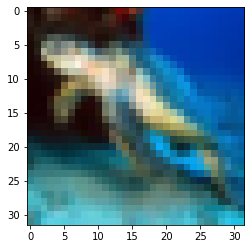

In [4]:
im_dir = './dataset/'
plt.imshow(img.imread(im_dir+tr_x[99]))
print(tr_y[99])

In [5]:
label = set(tr_y)
label = np.array(list(label))
label

array(['forest', 'orange', 'bed', 'crocodile', 'fox', 'kangaroo',
       'spider', 'pine_tree', 'mouse', 'lawn_mower', 'squirrel', 'plate',
       'bowl', 'sunflower', 'turtle', 'cockroach', 'dinosaur',
       'caterpillar', 'worm', 'flatfish', 'tractor', 'bear', 'seal',
       'bridge', 'snail', 'tiger', 'rabbit', 'apple', 'chair', 'pear',
       'hamster', 'couch', 'keyboard', 'oak_tree', 'television', 'boy',
       'streetcar', 'sea', 'clock', 'crab', 'man', 'shark', 'skyscraper',
       'rose', 'lamp', 'pickup_truck', 'wolf', 'can', 'sweet_pepper',
       'road', 'willow_tree', 'porcupine', 'mushroom', 'motorcycle',
       'bicycle', 'possum', 'maple_tree', 'house', 'lobster', 'train',
       'cloud', 'lizard', 'raccoon', 'rocket', 'woman', 'telephone',
       'bus', 'beaver', 'cattle', 'elephant', 'leopard', 'otter', 'camel',
       'plain', 'skunk', 'dolphin', 'aquarium_fish', 'butterfly', 'lion',
       'table', 'shrew', 'wardrobe', 'tulip', 'chimpanzee', 'girl',
       'tank', 

In [6]:
def tr_val(x_, y_):
    mask = np.ones(len(x_))
    mask[:int(len(mask)/5)] = 0 # #1:#0 = 4:1
    np.random.shuffle(mask)
    x_tr, x_vl = x_[mask==1], x_[mask==0]
    y_tr, y_vl = y_[mask==1], y_[mask==0]
    return x_tr, x_vl, y_tr, y_vl
def batch_div(x_, y_, num):
    x_b, y_b = [], []
    mask = np.tile(np.arange(int(len(x_)/num)), num)
    np.random.shuffle(mask)
    for i in range (int(len(x_)/num)):
        x_b.append(x_[mask==i])
        y_b.append(y_[mask==i])
    return int(len(x_)/num), x_b, y_b

# VGGnet
<https://arxiv.org/pdf/1409.1556.pdf>

In [7]:
trainx = np.array([img.imread(im_dir+u).T for i,u in enumerate(tr_x)])
trainy = np.zeros([len(tr_y), 100], dtype='int32')
for i,u in enumerate(label):
    for j,v in enumerate(tr_y):
        if v==u: trainy[j][i] = 1
            
testx = np.array([img.imread(im_dir+u).T for i,u in enumerate(ts_x)])
testy = np.zeros([len(ts_y), 100], dtype='int32')
for i,u in enumerate(label):
    for j,v in enumerate(ts_y):
        if v==u: testy[j][i] = 1
trainx, testx = torch.FloatTensor(trainx), torch.FloatTensor(testx)
trainy, testy = torch.FloatTensor(trainy), torch.FloatTensor(testy)

In [11]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.C1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.C2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.C3 = nn.Conv2d(64, 64, 3, 1, 1)
        self.W1 = nn.Linear(64*8*8, 1024)
        self.W2 = nn.Linear(1024, 256)
        self.W3 = nn.Linear(256, 100)
        self.S = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.C1(x)))
        x = F.relu(self.C2(x))
        x = self.pool(F.relu(self.C3(x)))
        x = x.view(-1, 64*64)
        x = F.relu(self.W2(F.relu(self.W1(x))))
        x = self.S(self.W3(x))
        return x
    
def loss1(output, y):
    #regular = reg*(torch.norm(self.W1.weight.data, p=1)+torch.norm(self.W2.weight.data, p=1))
    return F.binary_cross_entropy(output, y)+regular
def loss2(output, y):
    #regular = reg*(torch.norm(self.W1.weight.data)**2+torch.norm(self.W2.weight.data)**2)
    return F.binary_cross_entropy(output, y)

def accuracy(output, y):
    return torch.sum(torch.argmax(output, axis=1)==torch.argmax(y, axis=1))

In [12]:
reg = 0
model = VGG()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
n_epochs = 20
x_tr, x_vl, y_tr, y_vl = tr_val(trainx, trainy)
tr_loss, vl_loss = np.zeros(n_epochs, dtype='float64'), np.zeros(n_epochs, dtype='float64')
tr_accy, vl_accy, ts_accy = np.zeros_like(tr_loss), np.zeros_like(tr_loss), np.zeros_like(tr_loss)

for epoch in range(n_epochs):
    losst = 0.
    accyt = 0
    batchnum, x_tr_b, y_tr_b = batch_div(x_tr, y_tr, 100)
    for i in range (batchnum):
        output = model.forward(x_tr_b[i])
        loss = loss2(output, y_tr_b[i])
        accy = accuracy(output, y_tr_b[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losst += loss.item()
        accyt += accy
    
    output2 = model.forward(x_vl)
    tr_loss[epoch] = losst
    tr_accy[epoch] = accyt
    vl_loss[epoch] = loss2(output2, y_vl).item()
    vl_accy[epoch] = accuracy(output2, y_vl)
    ts_accy[epoch] = accuracy(model.forward(testx), testy)
    
    print("epoch:", epoch, "*test loss:", losst, "*val loss:", vl_loss[epoch], \
          "*tr/vl/ts accuracy:", tr_accy[epoch]/400, vl_accy[epoch]/100, ts_accy[epoch]/100)

epoch: 0 *test loss: 26.4348531588912 *val loss: 0.05636340752243996 *tr/vl/ts accuracy: 0.975 0.99 1.0
epoch: 1 *test loss: 21.00157667323947 *val loss: 0.04830930754542351 *tr/vl/ts accuracy: 5.3425 11.07 10.51
epoch: 2 *test loss: 18.609012730419636 *val loss: 0.04472928121685982 *tr/vl/ts accuracy: 13.45 16.36 16.05
epoch: 3 *test loss: 16.89576642587781 *val loss: 0.0405714213848114 *tr/vl/ts accuracy: 20.79 24.36 24.52
epoch: 4 *test loss: 15.650784030556679 *val loss: 0.03854693844914436 *tr/vl/ts accuracy: 26.375 27.47 28.06
epoch: 5 *test loss: 14.690866734832525 *val loss: 0.03654628247022629 *tr/vl/ts accuracy: 30.9125 31.45 31.76
epoch: 6 *test loss: 13.739498218521476 *val loss: 0.03601473197340965 *tr/vl/ts accuracy: 35.5525 33.48 33.39
epoch: 7 *test loss: 12.793089631944895 *val loss: 0.03499472141265869 *tr/vl/ts accuracy: 39.91 34.78 35.57
epoch: 8 *test loss: 11.860985223203897 *val loss: 0.03444777429103851 *tr/vl/ts accuracy: 44.6875 36.46 36.83
epoch: 9 *test loss

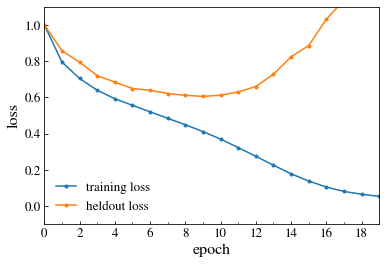

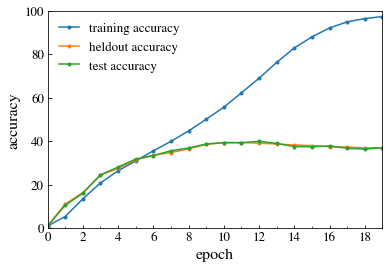

In [38]:
import matplotlib as mpl
import matplotlib.ticker as ticker
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 13 ,
    'xtick.top' : False ,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 13 ,
    'ytick.right' : False ,
    'axes.labelsize' : 16,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight'
})

plt.plot(tr_loss/tr_loss[0], '.-', label='training loss')
plt.plot(vl_loss/vl_loss[0], '.-', label='heldout loss')
plt.legend()
plt.ylim(-0.1, 1.1)
plt.xlim(0, 19)
plt.xlabel('epoch')
plt.ylabel('loss')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.savefig('vgg_loss.png')
plt.show()


plt.plot(tr_accy/400, '.-', label='training accuracy')
plt.plot(vl_accy/100, '.-', label='heldout accuracy')
plt.plot(ts_accy/100, '.-', label='test accuracy')
plt.ylim(0, 100)
plt.xlim(0, 19)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.savefig('vgg_acc.png')
plt.show()

In [14]:
def pred_img(num):
    im_dir = './dataset/'
    plt.imshow(img.imread(im_dir+ts_x[num]))
    plt.show()
    test_x = np.array([img.imread(im_dir+u).T for i,u in enumerate(ts_x[num:num+1])])
    test_x = torch.FloatTensor(test_x)
    print("real:", ts_y[num], "pred:", label[model.forward(test_x).argmax(axis=1)])
def correct_img():
    correct_ind = []
    im_dir = './dataset/'
    for i in range (10000):
        test_x = np.array([img.imread(im_dir+u).T for j,u in enumerate(ts_x[i:i+1])])
        test_x = torch.FloatTensor(test_x)
        test_y = ts_y[i]
        output = model.forward(test_x)
        if torch.argmax(output, axis=1)==torch.argmax(testy[i]):
            correct_ind.append(i)
    return correct_ind

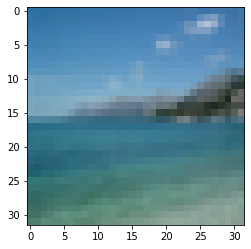

real: sea pred: sea


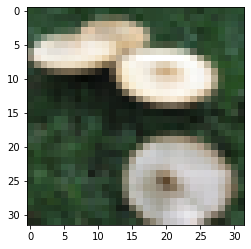

real: mushroom pred: mushroom


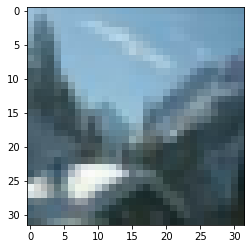

real: mountain pred: mountain


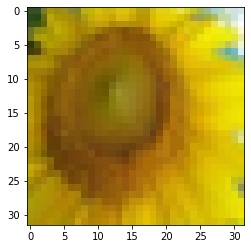

real: sunflower pred: sunflower


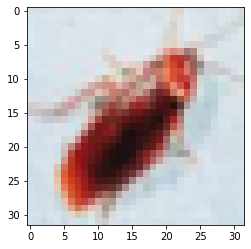

real: cockroach pred: cockroach


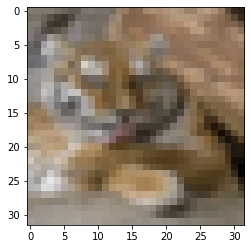

real: tiger pred: tiger


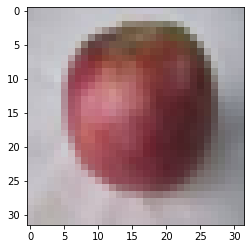

real: apple pred: apple


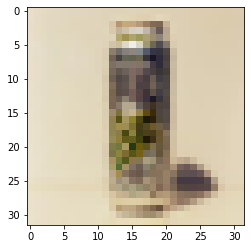

real: can pred: can


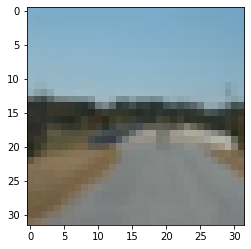

real: road pred: road


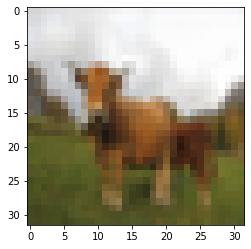

real: cattle pred: cattle


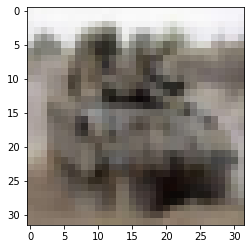

real: tank pred: tank


In [15]:
correct_ind = correct_img()
n=0
num=10
np.random.shuffle(correct_ind)
for i in correct_ind:
    plt.imshow(img.imread(im_dir+ts_x[i]))
    plt.show()
    test_x = np.array([img.imread(im_dir+u).T for j,u in enumerate(ts_x[i:i+1])])
    test_x = torch.FloatTensor(test_x)
    test_y = ts_y[i]
    print("real:", test_y, "pred:", label[model.forward(test_x).argmax(axis=1)])
    n+=1
    if n>num: break

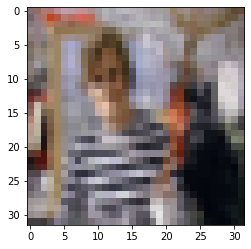

real: man pred: bed


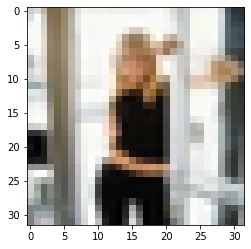

real: woman pred: girl


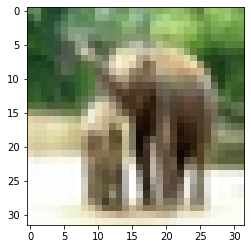

real: elephant pred: elephant


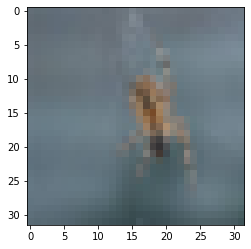

real: spider pred: spider


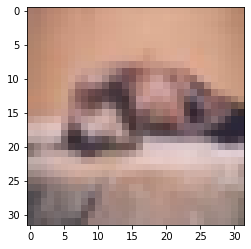

real: otter pred: seal


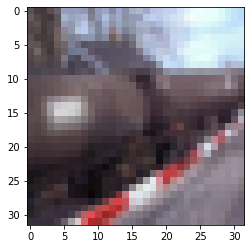

real: train pred: house


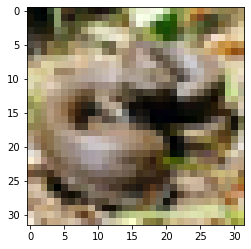

real: snake pred: caterpillar


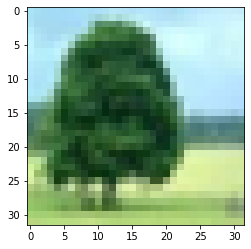

real: oak_tree pred: oak_tree


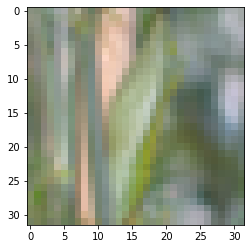

real: caterpillar pred: forest


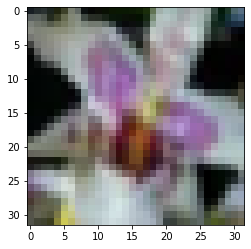

real: orchid pred: orchid


In [18]:
n=0
for i in np.random.randint(0, 10000, 10):
    plt.imshow(img.imread(im_dir+ts_x[i]))
    plt.show()
    test_x = np.array([img.imread(im_dir+u).T for j,u in enumerate(ts_x[i:i+1])])
    test_x = torch.FloatTensor(test_x)
    test_y = ts_y[i]
    print("real:", test_y, "pred:", label[model.forward(test_x).argmax(axis=1)])

In [26]:
a = []
b = []
for i in range(10000):
    #plt.imshow(img.imread(im_dir+ts_x[i]))
    #plt.show()
    a.append(ts_x[i])
    test_x = np.array([img.imread(im_dir+u).T for j,u in enumerate(ts_x[i:i+1])])
    test_x = torch.FloatTensor(test_x)
    b.append(label[model.forward(test_x).argmax(axis=1)])
a = np.array(a)
b = np.array(b)
np.savetxt('cifar100pred_vgg.csv', np.array([a, b]).T, fmt='%s', delimiter=',',\
          header='id,category')